In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from numpy import mean,std
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train_features = pd.read_csv('../datasets/training_set_features.csv')
train_labels = pd.read_csv('../datasets/training_set_labels.csv')
train_data = pd.merge(train_features, train_labels, on = 'respondent_id', how='inner')

test_features = pd.read_csv('../datasets/test_set_features.csv')

In [7]:
all_dataset = pd.concat([train_data, test_features])

In [8]:
train_data.shape

(26707, 38)

In [9]:
train_data.head(2)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1


# Encoding

In [10]:
label_encoder = preprocessing.LabelEncoder()

In [11]:
for col in ['age_group', 'education', 'race', 'sex', 
            'income_poverty', 'marital_status', 'rent_or_own', 
            'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']:
    all_dataset[col] = label_encoder.fit_transform(all_dataset[col].astype(str))

In [16]:
all_dataset.shape

(53415, 38)

# Handling Null Values

In [12]:
# Impute with mean & median
train_data_impute_mean = all_dataset.copy()

In [13]:
train_data_impute_mean.fillna(train_data_impute_mean.mean(), inplace=True)

In [14]:
dataset = train_data_impute_mean.copy()

In [15]:
submission_train_dataset = dataset.loc[dataset['respondent_id'] >= len(train_data)] 
submission_train_dataset = submission_train_dataset.drop(['h1n1_vaccine','seasonal_vaccine'], axis=1)
# submission_train_dataset.head()

In [16]:
dataset = dataset.loc[dataset['respondent_id'] < len(train_data)]

In [17]:
train_data['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

# Split Train 

In [18]:
y1 = dataset['h1n1_vaccine'].astype(int)
y2 = dataset['seasonal_vaccine'].astype(int)

X = dataset.drop(['h1n1_vaccine', 'seasonal_vaccine'], axis=1)


In [19]:
# X = X.drop(['respondent_id'], axis = 1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.25, random_state=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.25, random_state=1)

# Modeling

## Random Forest

### h1n1_vaccine

In [21]:
# define model
rf_model1 = RandomForestClassifier()
rf_model1.fit(X_train1, y_train1)

RandomForestClassifier()


In [22]:
score = rf_model1.score(X_train1, y_train1)
print("Training Score: ", score)
print("="*100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_auc_scores = cross_val_score(rf_model1, X_train1, y_train1, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.5f' % mean(roc_auc_scores))
print("="*100)

y_pred1 = rf_model1.predict(X_test1)
cm = confusion_matrix(y_test1, y_pred1)
print("Confusion Matrix\n", cm)
print("="*100)

cr = classification_report(y_test1, y_pred1)
print("Classification Report \n", cr)

Training Score:  1.0
Mean ROC AUC: 0.85385
Confusion Matrix
 [[5055  208]
 [ 767  647]]
Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      5263
           1       0.76      0.46      0.57      1414

    accuracy                           0.85      6677
   macro avg       0.81      0.71      0.74      6677
weighted avg       0.84      0.85      0.84      6677



In [27]:
train_scores, test_scores = list(), list()

last_column = len(X_train1.columns)+1

values = [i for i in range(1,last_column)]

# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = rf_model1
	# fit model on the training dataset
	model.fit(X_train1, y_train1)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train1)
	train_acc = accuracy_score(y_train1, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test1)
	test_acc = accuracy_score(y_test1, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	# print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

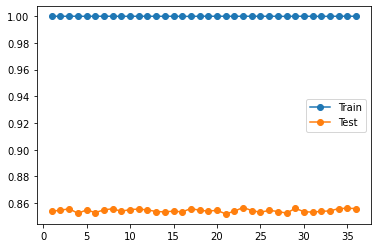

In [28]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')

plt.legend()
plt.show()

### seasonal_vaccine

In [29]:
# define model
rf_model2 = RandomForestClassifier()
rf_model2.fit(X_train2, y_train2)

RandomForestClassifier()

In [30]:
score = rf_model2.score(X_train2, y_train2)
print("Training Score: ", score)
print("="*100)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_auc_scores = cross_val_score(rf_model2, X_train2, y_train2, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.5f' % mean(roc_auc_scores))
print("="*100)

y_pred2 = rf_model2.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred2)
print("Confusion Matrix\n", cm)
print("="*100)

cr = classification_report(y_test2, y_pred2)
print("Classification Report \n", cr)

Training Score:  1.0
Mean ROC AUC: 0.84828
Confusion Matrix
 [[2953  686]
 [ 742 2296]]
Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.81      0.81      3639
           1       0.77      0.76      0.76      3038

    accuracy                           0.79      6677
   macro avg       0.78      0.78      0.78      6677
weighted avg       0.79      0.79      0.79      6677



In [31]:
train_scores, test_scores = list(), list()

last_column = len(X_train1.columns)+1

values = [i for i in range(1,last_column)]

# evaluate a decision tree for each depth
for i in values:
	# configure the model
	model = rf_model2
	# fit model on the training dataset
	model.fit(X_train1, y_train1)
	# evaluate on the train dataset
	train_yhat = model.predict(X_train1)
	train_acc = accuracy_score(y_train1, train_yhat)
	train_scores.append(train_acc)
	# evaluate on the test dataset
	test_yhat = model.predict(X_test1)
	test_acc = accuracy_score(y_test1, test_yhat)
	test_scores.append(test_acc)
	# summarize progress
	# print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

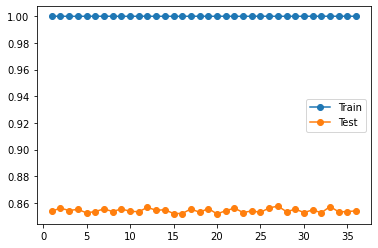

In [33]:
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')

plt.legend()
plt.show()

## Predictions

In [ ]:
# test_features = test_features.fillna(0, inplace=True)
# test_features.head(1)

In [34]:
h1n1_vaccine_submission = rf_model2.predict(submission_train_dataset).astype(int)
seasonal_vaccine_submission = rf_model2.predict(submission_train_dataset).astype(int)

In [35]:
submission_train_dataset.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,1.0,1.0,5.0,1.0,1.0,1,2,1,0,1,1,1,0,7,0,1.0,0.0,1,7
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.0,1.0,1.0,4.0,1.0,1.0,0,0,3,1,2,1,1,0,1,2,3.0,0.0,1,21
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.883824,5.0,4.0,2.0,5.0,4.0,4.0,3,2,3,1,1,0,0,0,5,2,1.0,0.0,11,13
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.000000,4.0,2.0,2.0,4.0,4.0,2.0,4,0,3,0,0,0,0,1,5,0,1.0,0.0,10,11
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,5.0,2.0,4.0,4.0,4.0,2.0,1,0,0,0,0,1,0,0,6,2,0.0,1.0,4,10


In [36]:
submission = pd.DataFrame({
                            "respondent_id": test_features.respondent_id,
                            "h1n1_vaccine": h1n1_vaccine_submission.astype('float64'),
                            "seasonal_vaccine": seasonal_vaccine_submission.astype('float64')
    })

In [37]:
submission.head(5)

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.0,0.0
1,26708,0.0,0.0
2,26709,0.0,0.0
3,26710,1.0,1.0
4,26711,0.0,0.0


In [38]:
submission.to_csv('baseline_XGBOOST_submission.csv', index=False)